In [1]:
#Importing necessary Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from math import ceil
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, \
    f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


In [3]:
def transform_dataset(dataset: pd.DataFrame):
    df = dataset.copy()
    df['CAN ID'] = df['CAN ID'].apply(lambda i: int(i, 16))
    df['Flag'] = df['Flag'].apply(lambda x: 0 if x == 'R' else 1)

    for i in range(8):
        df[f'DATA{i}'] = df[f'DATA{i}'].apply(lambda i: int(i, 16))

    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    
    return df

In [4]:
# Training data for baseline model and GridSearch
def splitting_data(dataset: pd.DataFrame):
    data_size = len(dataset)
    train_size = ceil(data_size * .6)
    val_size = ceil((data_size - train_size) * .25)
    # print(train_size, test_size)
    train = dataset.iloc[:train_size]
    vali = dataset.iloc[train_size:train_size+val_size]
    test = dataset.iloc[train_size+val_size:]

    X_train = train.drop(columns=['Flag'])
    y_train = train['Flag']

    X_val = vali.drop(columns=['Flag'])
    y_val = vali['Flag']

    X_test = test.drop(columns=['Flag'])
    y_test = test['Flag']
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
folder_path = '{0}_dataset.csv'
column_names = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
attacks = {}
for attack in ['DoS', 'Fuzzy', 'gear', 'RPM']:
    data = pd.read_csv(folder_path.format(attack), names=column_names)
    data = data.dropna()
    attacks[attack] = data

In [6]:
for att, data in attacks.items():
    attacks[att] = transform_dataset(data)

In [ ]:
data.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,790,8,5,33,104,9,33,33,0,111,0
1,1.478198e+09,399,8,254,91,0,0,0,60,0,0,0
2,1.478198e+09,608,8,25,33,34,48,8,142,109,58,0
3,1.478198e+09,672,8,100,0,154,29,151,2,189,0,0
4,1.478198e+09,809,8,64,187,127,20,17,32,0,20,0


In [7]:
model_data = {
    "X_train": [],
    "X_val": [],
    "X_test": [],
    "y_train": [],
    "y_test": [],
    "y_val": [],
}

for att, data in attacks.items():
    x_tr, x_val, x_te, y_tr, y_val, y_te = splitting_data(data)
    model_data["X_train"].append(x_tr)
    model_data["X_val"].append(x_val)
    model_data["X_test"].append(x_te)
    model_data["y_train"].append(y_tr)
    model_data["y_val"].append(y_val)
    model_data["y_test"].append(y_te)

In [8]:
X_train = pd.concat(model_data["X_train"])
y_train = pd.concat(model_data["y_train"]).values

# For feature selection validation
X_train_pca = X_train.drop(columns=['DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA6'])
X_train_tsvd = X_train.drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6'])
X_test_pca = pd.concat(model_data["X_test"]).drop(columns=['DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA6'])
X_test_tsvd = pd.concat(model_data["X_test"]).drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6'])
y_test_fe = pd.concat(model_data["y_test"])

X_train = X_train.values
X_train_pca = X_train_pca.values
X_train_tsvd = X_train_tsvd.values
X_test_pca = X_test_pca.values
X_test_tsvd = X_test_tsvd.values
y_test_fe = y_test_fe.values

Baseline model to compare the Features selected by the methods

In [9]:
dtc_pca = KNeighborsClassifier()
dtc_tsvd = KNeighborsClassifier()

for fe_type, xtr, xte, model in [('PCA', X_train_pca, X_test_pca, dtc_pca), ('TSVD', X_train_tsvd, X_test_tsvd, dtc_tsvd)]:
    start_time = datetime.now()
    model.fit(xtr, y_train)
    end_time = datetime.now()
    time_diff = end_time - start_time
    print(f"Training time: {time_diff.total_seconds() / 60}")

    y_pred = model.predict(xte)
    print(
        f"""
        {fe_type}
        Accuracy: {accuracy_score(y_test_fe, y_pred)}
        Precision: {precision_score(y_test_fe, y_pred)}
        Recall: {recall_score(y_test_fe, y_pred)}
        F1-Score: {f1_score(y_test_fe, y_pred)}
        ROC AUC: {roc_auc_score(y_test_fe, y_pred)}
        """
    )

Training time: 0.39910946666666663

        PCA
        Accuracy: 0.9793399596264356
        Precision: 0.836838611009022
        Recall: 0.6563072402860038
        F1-Score: 0.7356591974986973
        ROC AUC: 0.8252226454749289
        
Training time: 0.39279580000000003

        TSVD
        Accuracy: 0.9790974249990684
        Precision: 0.8337617009657563
        Recall: 0.653006480646391
        F1-Score: 0.7323963490462002
        ROC AUC: 0.8235210468062454
        


The performance of TSVD and PCA are almost similar. For robust experiment, we referred the result of decision tree and random forest. Their results are slight better on TSVD. Therefore, we will be using the features selected by TSVD to conduct the evaluation on baseline model, K-fold cross validation and Hyperparameter tuning (Grid Search).

In [10]:
dtc_baseline = dtc_tsvd

X_train = X_train_tsvd
model_data["X_val"] = [ x_val.drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6']) for x_val in model_data["X_val"]]
model_data["X_test"] = [ x_test.drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6']) for x_test in model_data["X_test"]]
X_val = pd.concat(model_data["X_val"]).values
X_test = pd.concat(model_data["X_test"]).values
model_data["X_val"] = [ x_val.values for x_val in model_data["X_val"]]
model_data["X_test"] = [ x_test.values for x_test in model_data["X_test"]]

y_val = pd.concat(model_data["y_val"]).values
y_test = pd.concat(model_data["y_test"]).values
model_data["y_val"] = [y_val.values for y_val in model_data["y_val"]]
model_data["y_test"] = [y_test.values for y_test in model_data["y_test"]]

In [11]:
# To keep track of the validation training loss using mean squaread error
train_mses = []
val_mses = {
    'DoS': [],
    'Fuzzy': [],
    'gear': [],
    'RPM': [],
}

Baseline model prediction for each attack


    Overall performance
    Accuracy: 0.9790974249990684
    Precision: 0.8337617009657563
    Recall: 0.653006480646391
    F1-Score: 0.7323963490462002
    ROC AUC: 0.8235210468062454

    


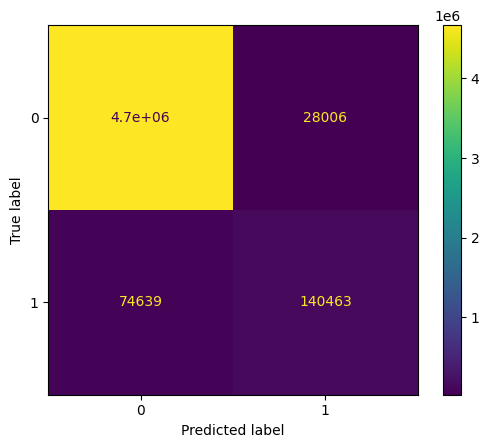

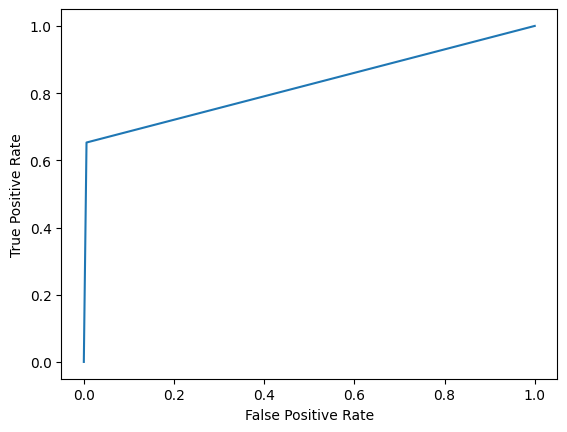

In [12]:
y_train_pred = dtc_baseline.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mses.append(train_mse)

y_pred_base = dtc_baseline.predict(X_test)
print(
    f"""
    Overall performance
    Accuracy: {accuracy_score(y_test, y_pred_base)}
    Precision: {precision_score(y_test, y_pred_base)}
    Recall: {recall_score(y_test, y_pred_base)}
    F1-Score: {f1_score(y_test, y_pred_base)}
    ROC AUC: {roc_auc_score(y_test, y_pred_base)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_base)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_base)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


        DoS performance
        Accuracy: 0.9931601450511476
        Precision: 0.7394312067640276
        Recall: 1.0
        F1-Score: 0.8501988510826336
        ROC AUC: 0.9965123782979957

        

        Fuzzy performance
        Accuracy: 0.9594154834329507
        Precision: 0.286747780335416
        Recall: 0.06261518944924484
        F1-Score: 0.1027857451573612
        ROC AUC: 0.5283049007446846

        

        gear performance
        Accuracy: 0.9943091486662043
        Precision: 0.9018078741803172
        Recall: 1.0
        F1-Score: 0.9483690612743919
        ROC AUC: 0.9969976554792688

        

        RPM performance
        Accuracy: 0.9694338049017989
        Precision: 0.8795643345024922
        Recall: 0.573205649527201
        F1-Score: 0.6940826850799754
        ROC AUC: 0.784075993643762

        


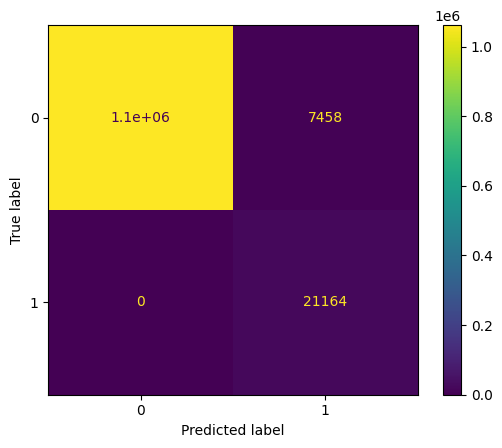

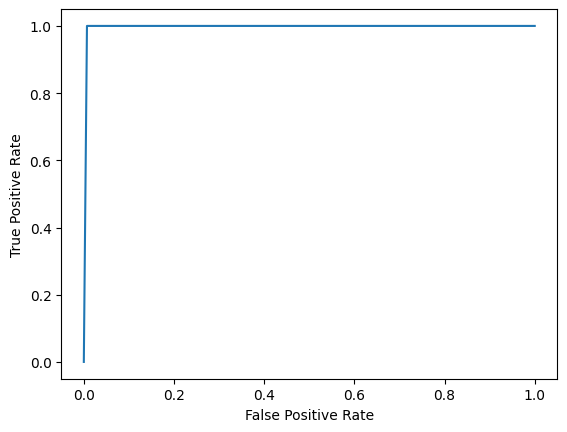

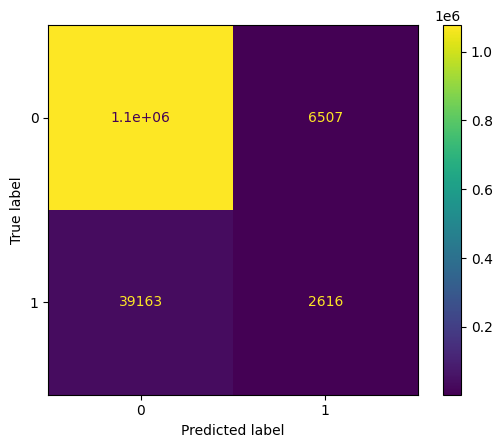

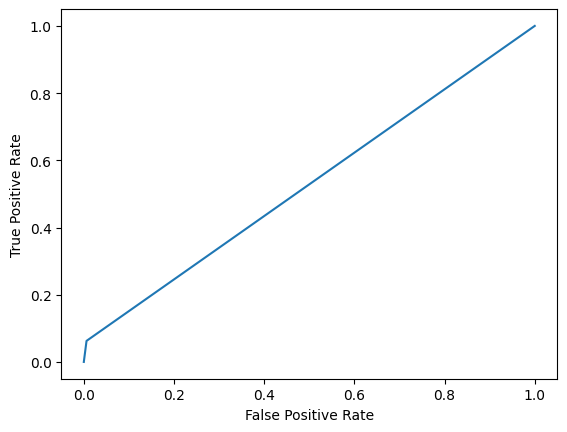

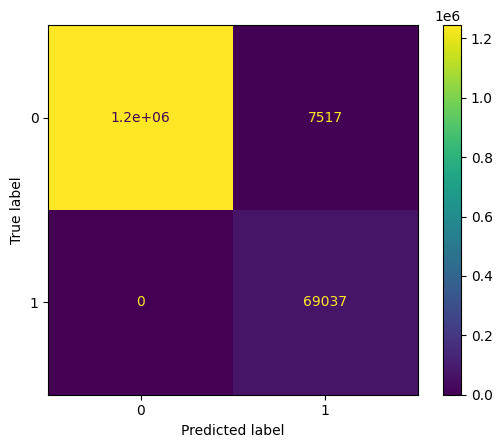

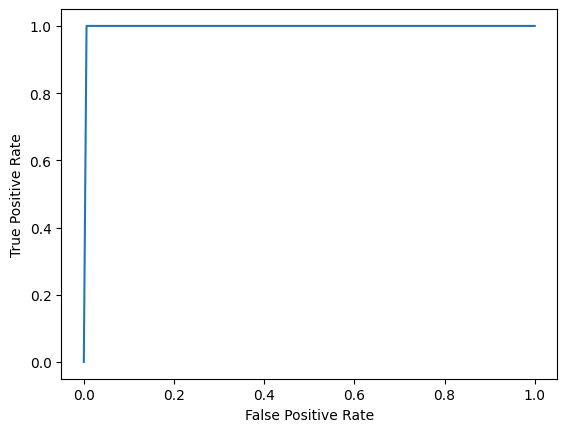

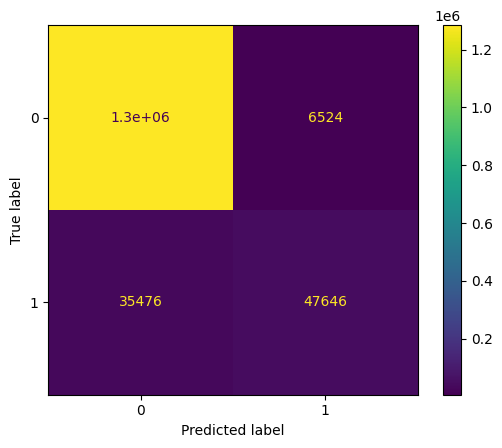

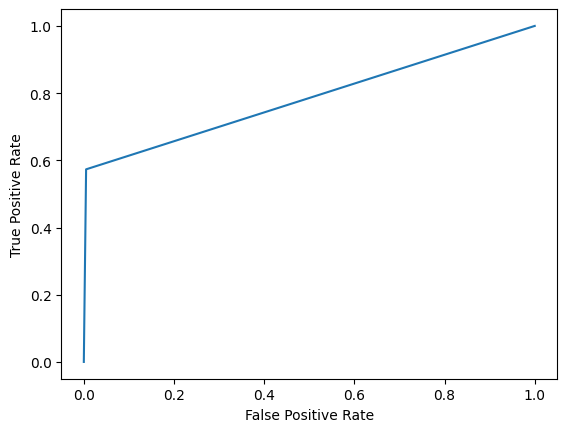

In [13]:
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_val_pred = dtc_baseline.predict(model_data["X_val"][i])
    val_mse = mean_squared_error(model_data["y_val"][i], y_val_pred)
    val_mses[att].append(val_mse)


    y_pred_att = dtc_baseline.predict(model_data["X_test"][i])

    print(
        f"""
        {att} performance
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )
    conf_matrix = confusion_matrix(model_data["y_test"][i], y_pred_att)
    cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
    fpr, tpr, _ = roc_curve(model_data["y_test"][i], y_pred_att)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

K-Fold cross validation

In [ ]:
dtc_5_fold = KNeighborsClassifier()
start_time = datetime.now()
dtc_5_fold = GridSearchCV(dtc_5_fold, param_grid={}, cv=5, scoring='accuracy')
dtc_5_fold.fit(X_train, y_train)
end_time = datetime.now()
time_diff = end_time - start_time
print(f"Training time: {time_diff.total_seconds() / 60}")

Training time: 9.487079266666665



    Accuracy: 0.9790974249990684
    Precision: 0.8337617009657563
    Recall: 0.653006480646391
    F1-Score: 0.7323963490462002
    ROC AUC: 0.8235210468062454

    


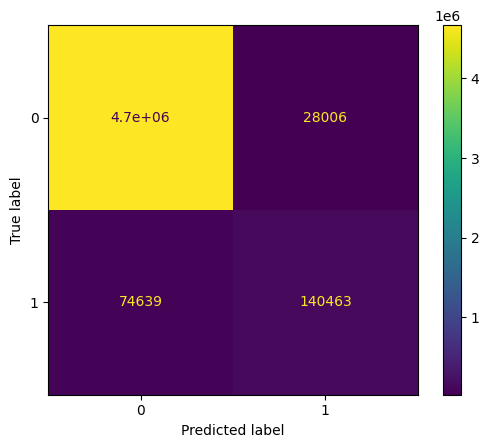

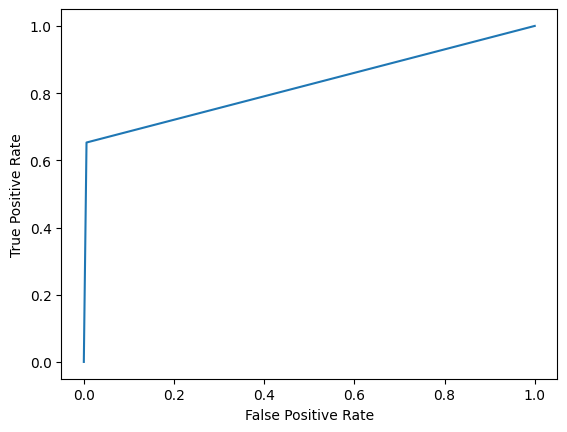

In [ ]:
y_pred_k_fold = dtc_5_fold.predict(X_test)
print(
    f"""
    Accuracy: {accuracy_score(y_test, y_pred_k_fold)}
    Precision: {precision_score(y_test, y_pred_k_fold)}
    Recall: {recall_score(y_test, y_pred_k_fold)}
    F1-Score: {f1_score(y_test, y_pred_k_fold)}
    ROC AUC: {roc_auc_score(y_test, y_pred_k_fold)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_k_fold)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_k_fold)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_pred_att = dtc_5_fold.predict(model_data["X_test"][i])
    print(
        f"""
        {att}
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )


        DoS
        Accuracy: 0.9931601450511476
        Precision: 0.7394312067640276
        Recall: 1.0
        F1-Score: 0.8501988510826336
        ROC AUC: 0.9965123782979957

        

        Fuzzy
        Accuracy: 0.9594154834329507
        Precision: 0.286747780335416
        Recall: 0.06261518944924484
        F1-Score: 0.1027857451573612
        ROC AUC: 0.5283049007446846

        

        gear
        Accuracy: 0.9943091486662043
        Precision: 0.9018078741803172
        Recall: 1.0
        F1-Score: 0.9483690612743919
        ROC AUC: 0.9969976554792688

        

        RPM
        Accuracy: 0.9694338049017989
        Precision: 0.8795643345024922
        Recall: 0.573205649527201
        F1-Score: 0.6940826850799754
        ROC AUC: 0.784075993643762

        


Grid Search

In [ ]:
params_grid = {
    'n_neighbors' : [3,5,7],
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan']
}

dtc_grid_search = KNeighborsClassifier()
start_time = datetime.now()
grid_search = GridSearchCV(dtc_grid_search, params_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
end_time = datetime.now()
time_diff = end_time - start_time
print(f"Training time: {time_diff.total_seconds() / 60}")

Training time: 102.31911471666668


Grid Search
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Accuracy: 0.7929933715511054

    Accuracy: 0.9952892077792728
    Precision: 0.9970019727951037
    Recall: 0.8951474184340452
    F1-Score: 0.9433332761758718
    ROC AUC: 0.9475120549270021

    


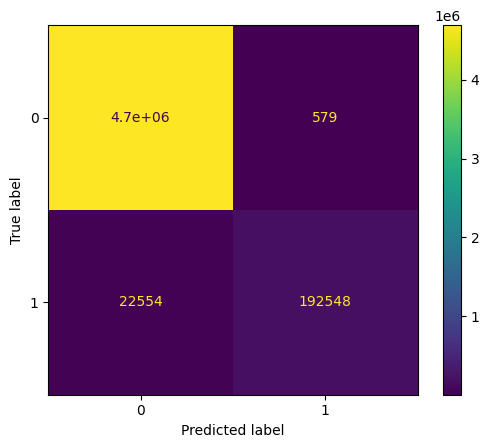

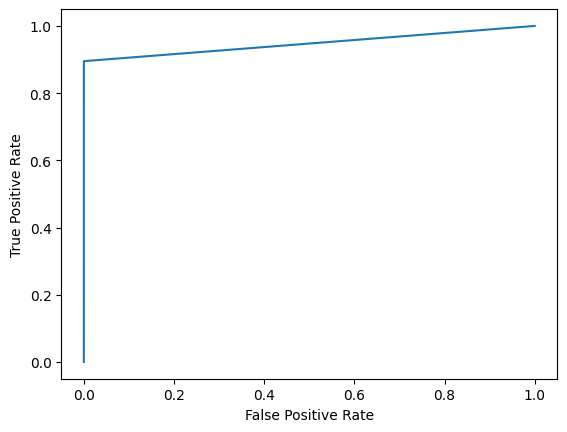

In [ ]:
print('Grid Search')
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)
y_pred_gs = grid_search.predict(X_test)
print(
    f"""
    Accuracy: {accuracy_score(y_test, y_pred_gs)}
    Precision: {precision_score(y_test, y_pred_gs)}
    Recall: {recall_score(y_test, y_pred_gs)}
    F1-Score: {f1_score(y_test, y_pred_gs)}
    ROC AUC: {roc_auc_score(y_test, y_pred_gs)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_gs)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_gs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
# Prediction for each attack
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_pred_att = grid_search.predict(model_data["X_test"][i])

    print(
        f"""
        {att}
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )


        DoS
        Accuracy: 0.9998550955910541
        Precision: 0.992589813338336
        Recall: 1.0
        F1-Score: 0.9962811279009556
        ROC AUC: 0.9999261136727116

        

        Fuzzy
        Accuracy: 0.9798321523212353
        Precision: 0.9927191985954766
        Recall: 0.4601594102300199
        F1-Score: 0.6288331016436339
        ROC AUC: 0.7300146398236051

        

        gear
        Accuracy: 0.9999008245942893
        Precision: 0.9981060606060606
        Recall: 1.0
        F1-Score: 0.9990521327014218
        ROC AUC: 0.9999476776463727

        

        RPM
        Accuracy: 0.9998915627840563
        Precision: 0.998210661574858
        Recall: 1.0
        F1-Score: 0.999104529637665
        ROC AUC: 0.9999422903376983

        


Custom Grid Search

In [ ]:
n_neighbors = [3,5,7]
weights = ["uniform", "distance"]
metric = ['euclidean', 'manhattan']

temp_grid = [{ "n_neighbors": nb, "weights": wt } for wt in weights for nb in n_neighbors]
params_grid = []
for mt in metric:
    for tg in temp_grid:
        pg = tg.copy()
        pg["metric"] = mt
        params_grid.append(pg)

for param_grid in params_grid:
    dtc = KNeighborsClassifier(**param_grid)
    dtc.fit(X_train, y_train)
  

    y_train_pred = dtc.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mses.append(train_mse)

    for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
        # evaluate the accuracy on the validation set
        y_val_pred = dtc.predict(model_data["X_val"][i])
        val_mse = mean_squared_error(model_data["y_val"][i], y_val_pred)
        val_mses[att].append(val_mse)

        y_pred_att = dtc.predict(model_data["X_test"][i])




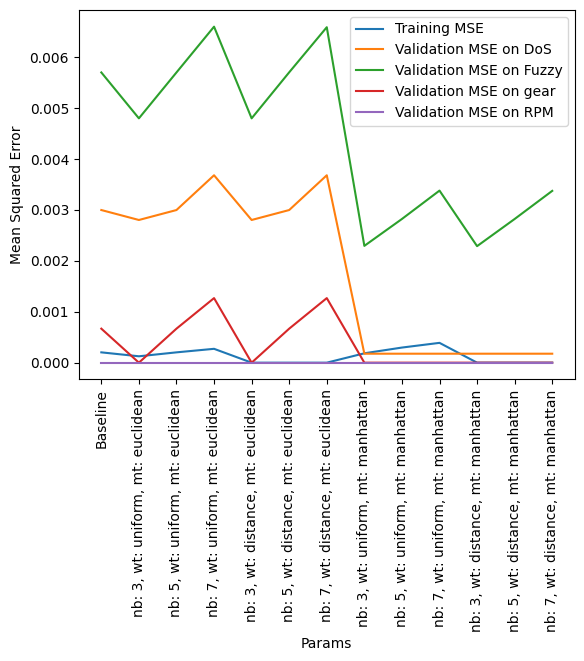

In [ ]:
params = ["Baseline"]
temp = [f"nb: {p['n_neighbors']}, wt: {p['weights']}, mt: {p['metric']}" for p in params_grid]
params.extend(temp)
# print(params)
plt.plot(params, train_mses, label='Training MSE')
for att in ['DoS', 'Fuzzy', 'gear', 'RPM']:
    plt.plot(params, val_mses[att], label=f'Validation MSE on {att}')
plt.xlabel('Params')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=90)
plt.legend()
plt.show()